<a href="https://colab.research.google.com/github/smmurdock/Neural-Network-Sentiment-Analysis/blob/main/d604_task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# D604 Task 2 - Sentiment Analysis Using Neural Networks

In [1]:
cd /content/drive/MyDrive/1 Projects/_WGU | MS-DataAnalytics-DataScience/WGU | D604 - ADVANCED ANALYTICS/Task 2 - Sentiment Analysis Using Neural Networks

/content/drive/MyDrive/1 Projects/_WGU | MS-DataAnalytics-DataScience/WGU | D604 - ADVANCED ANALYTICS/Task 2 - Sentiment Analysis Using Neural Networks


## A. Research Purpose

> Describe the purpose of this data analysis by doing the following:

### A1. Research Question

> Summarize one research question that you will answer using a neural network model and NLP techniques. Be sure the research question is relevant to a real-world organizational situation and sentiment analysis captured in your chosen dataset or datasets.


  Note: If you choose to use more than one dataset, you must concatenate them into one dataset for parts II and III.

**Research Question:** Can a neural network be trained to accurately classify sentiment in customer product reviews from Amazon as either positive or negative?

This question is directly relevant to a real-world organizational situation. For a company like Amazon or any third-party seller on its platform, manually sifting through thousands of customer reviews to gauge public opinion is impractical based on the sheer volume of Amazon's product catalog. A system that can accurately classify sentiment allows an organization to quickly monitor customer feedback at scale. This enables them to identify popular product features, detect widespread product defects, determine if a product is likely to be returned, and track shifts in customer satisfaction over time, leading to faster product improvements and better customer service.

### A2. Objectives or Goals

> Define the objectives or goals of the data analysis. Be sure each objective or goal is reasonable within the scope of the research question and is represented in the available data.

The primary goals of this data analysis are to design, build, and evaluate a neural network for sentiment classification. The specific objectives are as follows:

* **Data Preprocessing:** To clean and prepare the raw text data from the Amazon reviews dataset for modeling.

* **Model Development:** To build and train a suitable neural network. This analysis will use an LSTM-based architecture, which is effective for learning from sequential data like text. The goal is to train the model to recognize patterns and contextual cues in word usage that indicate positive or negative sentiment.

* **Model Evaluation:** To assess the performance of the trained model on an unseen test dataset. The objective is to quantify its predictive accuracy using key classification metrics. This evaluation will directly answer how effectively the model can classify new, unseen review data.

### A3. Prescribed Network

> Identify an industry-relevant type of neural network capable of performing a text classification task that can be trained to produce useful predictions on text sequences on the selected dataset.

An appropriate and industry-relevant neural network for this text sentiment classification tasks is the **Long Short-Term Memory (LSTM)** neural network.

LSTMs are a type of **Recurrent Neural Network (RNN)** specifically designed to handle and learn from sequential data like text, where the order of text matters. Unlike standard RNNs, LSTMs have internal memory cells that can maintain information over long sequences (Audevart et al., 2021, p. 272). This capability is crucial for natural language processing because the meaning of a word often depends on its context (Ahmad, 2023, p. 333). An LSTM can capture these dependencies, allowing it to understand nuances in language that are critical for accurately determining sentiment. This makes LSTMs a powerful and widely used tool for sentiment analysis in real-world applications.

## B. Data Preparation

> Summarize the data cleaning process by doing the following:

### B1. Data Exploration

> Perform exploratory data analysis on the chosen dataset, and include an explanation of each of the following elements:

  * presence of unusual characters (e.g., emojis, non-English characters)
  * vocabulary size
  * word embedding length
  * statistical justification for the chosen maximum sequence length

In [2]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the display options for better readability
pd.set_option('display.max_colwidth', 100)

The code cell above loads in the basic libraries needed to get started and sets the DataFrame's maximum column width to '100' for better readability.

In [3]:
# Load the data
df = pd.read_csv('amazon_cells_labelled.txt',
                 sep='\t',
                 header=None,
                 names=['review', 'sentiment'])

The code cell above loads in the the text file as a tab-delimited file with no headers identifying what the observations mean. Because of this, I looked at the data ahead of time and determined appropriate names to act as column headers.

In [4]:
# View the first few rows
print("First 5 rows:")
df.head()

First 5 rows:


,review,sentiment
0,So there is no way for me to plug it in here in the US unless I go by a converter.,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!,0
4,The mic is great.,1


The code cell above reads in the first five rows and gives a glimpse of how the data is formatted and what issues may present themselves. We can already seem some issues like use of punctuation, differences in casing, and missing spaces in between sentences.

In [5]:
# Check shape
print(f"Dataset shape: {df.shape}")
print(f"Total reviews: {df.shape[0]}")
print(f"Total columns: {df.shape[1]}")

Dataset shape: (1000, 2)
Total reviews: 1000
Total columns: 2


The code cell above uses Pandas DataFrame properties to check for how many rows and columns are present, indicating there are 1,000 rows and 2 columns. This is a fairly small, fairly simply DataFrame.

In [6]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())
print(f"\nTotal missing: {df.isnull().sum().sum()}")

Missing values:
review       0
sentiment    0
dtype: int64

Total missing: 0


The code cell above checks for the presence of any missing values. The presence of missing values determines the logical flow of EDA by determining if there are further preprocessing steps to take (e.g., remove the observations with missing data or fill the missing data with a determined value).

There are no missing values in this dataset, so we can move on without needing to address any missing values.

In [7]:
# Check for duplicates
print(f"Number of duplicate rows: {df.duplicated().sum()}")
print(f"Percentage of duplicates: {df.duplicated().sum() / len(df) * 100:.2f}%")

Number of duplicate rows: 10
Percentage of duplicates: 1.00%


The code cell above checks for the presence of any duplicate observations and how prevalent they are.

The code finds 10 instances of duplicates, which accounts for 1% of the total dataset.

In [8]:
# Find and examine duplicate reviews
duplicates = df[df.duplicated(subset=['review'], keep=False)]
duplicates_sorted = duplicates.sort_values('review')

print(f"Total duplicate entries: {len(duplicates)}")
print("\nSample of duplicate reviews:")
duplicates_sorted.head(20)

Total duplicate entries: 20

Sample of duplicate reviews:


,review,sentiment
446,Does not fit.,0
748,Does not fit.,0
180,Don't buy this product.,0
543,Don't buy this product.,0
402,Excellent product for the price.,1
892,Excellent product for the price.,1
792,Great Phone.,1
290,Great Phone.,1
187,Great phone!.,1
285,Great phone!.,1


The code cell above pulls out the duplicates and sorts them by ascending alphabetical order so that they are paired together by value rather than row ID. This step is valuable so we can determine if any of the duplicates appear to be legitimate or they appear to be actual duplicates.

Based on the small number of duplicates and the presence of the same unusual punctuation combinations appearing in a few of the examples, we can remove all duplicates while keeping the first occurrence.

In [9]:
# Remove exact duplicates, keeping the first occurrence
df_clean = df.drop_duplicates(keep='first')

print(f"Original dataset: {len(df)} rows")
print(f"After removing duplicates: {len(df_clean)} rows")
print(f"Duplicates removed: {len(df) - len(df_clean)}")

Original dataset: 1000 rows
After removing duplicates: 990 rows
Duplicates removed: 10


The code cell above removes the duplicate rows, keeping the first occurrence of the value and saving the results in a new copy of the DataFrame. It then checks the size of the cleaned DataFrame to confirm the removal of duplicates and compares the size to the original DataFrame.

In [10]:
# Check unique values in sentiment column
print("Unique sentiment values:")
print(df_clean['sentiment'].unique())
print(f"Number of unique sentiment values: {df_clean['sentiment'].nunique()}")

Unique sentiment values:
[0 1]
Number of unique sentiment values: 2


The code cell above checks the DataFrame's `'sentiment'` column for unique values to ensure that there are only the expected binary values of `0` for negative sentiment and `1` for positive sentiment. There are no unexpected values.

In [11]:
# Check for class balance
print("Sentiment distribution:")
print(df_clean['sentiment'].value_counts())
print("\nSentiment distribution (percentages):")
print(df_clean['sentiment'].value_counts(normalize=True) * 100)

Sentiment distribution:
sentiment
0    497
1    493
Name: count, dtype: int64

Sentiment distribution (percentages):
sentiment
0    50.20202
1    49.79798
Name: proportion, dtype: float64


The code cell above checks how balanced the sentiment is across negative and positive reviews, both in actual numbers and in proportion to the full remaining dataset.

After removing the duplicates, there are 497 negative reviews and 493 positive reviews. Based on the small difference, we can consider this dataset to be balanced.

This information is important to keep in mind for when we split our datasets into train/validation/test datasets later in step **B5. Steps to Prepare the Data**, as we'll want to keep the proportions while shuffling the data. This ensures that the model *can't* learn from patterns that occur based on what order the data was added to the dataset but that it *can* learn, validate, and test fairly across representative proportions.

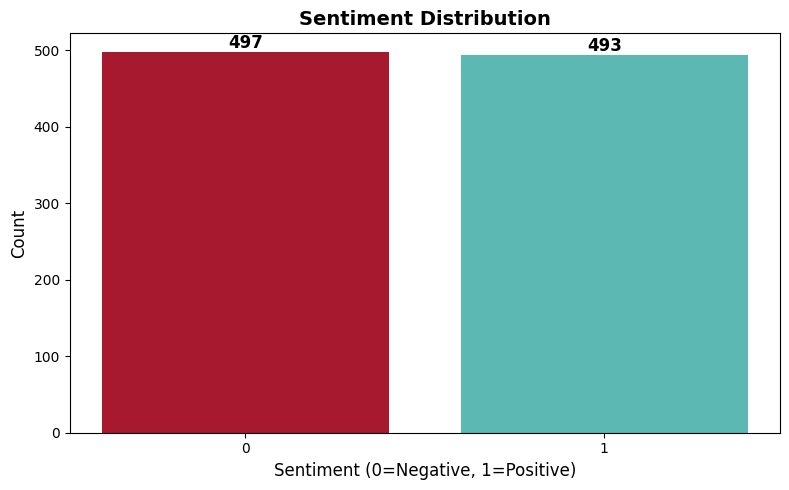

In [12]:
# Visualize class balance
plt.figure(figsize=(8, 5))
sentiment_counts = df_clean['sentiment'].value_counts()
bars = plt.bar(sentiment_counts.index, sentiment_counts.values, color=['#A6192E', '#5CB8B2'])

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Sentiment Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment (0=Negative, 1=Positive)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1])
plt.tight_layout()
plt.show()

The code cell above visualizes the class balance of negative and positive sentiment observations for the full cleaned dataset. The exact values are added above each bar because they are nearly indecipherable at a visual glance.

#### Presence of unusual characters

**Analyze Unusual Characters Before Cleaning**

Working definition of unusual characters: Any emojis, non-English characters, non-Unicode characters, punctuation, or control characters

In [13]:
# Load additional libraries
import re
import string
from collections import Counter

In [23]:
# Convert all text to lowercase for consistent analysis
df_clean.loc[:, 'review_lower'] = df_clean['review'].str.lower()
df_clean.head()

,review,sentiment,review_lower,review_clean
0,So there is no way for me to plug it in here in the US unless I go by a converter.,0,so there is no way for me to plug it in here in the us unless i go by a converter.,so there is no way for me to plug it in here in the us unless i go by a converter
1,"Good case, Excellent value.",1,"good case, excellent value.",good case excellent value
2,Great for the jawbone.,1,great for the jawbone.,great for the jawbone
3,Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!,0,tied to charger for conversations lasting more than 45 minutes.major problems!!,tied to charger for conversations lasting more than minutes major problems
4,The mic is great.,1,the mic is great.,the mic is great


The code cell above creates a new column in the DataFrame, `review_lower` that converts all text to lowercase. This avoids duplicating words or letters (e.g. "Good" is different from "good" and "A" is different from "a").

In [24]:
# Combine all text into one string to analyze all characters at once
all_text = ' '.join(df_clean['review_lower'].astype(str))

# Get all unique characters and their frequencies
char_frequency = Counter(all_text)

# Categorize characters
# (Python Documentation - string module)
letters = set(string.ascii_lowercase)  # a-z
digits = set(string.digits)  # 0-9
punctuation = set(string.punctuation)  # !"#$%&'()*+, etc.
whitespace = set(string.whitespace)  # space, tab, newline, etc.

# Categorize each character
categorized_chars = {
    'letters': {},
    'digits': {},
    'punctuation': {},
    'whitespace': {},
    'unusual': {}  # Anything else (emojis, non-English, etc.)
}

for char, count in char_frequency.items():
    if char in letters:
        categorized_chars['letters'][char] = count
    elif char in digits:
        categorized_chars['digits'][char] = count
    elif char in punctuation:
        categorized_chars['punctuation'][char] = count
    elif char in whitespace:
        categorized_chars['whitespace'][char] = count
    else:
        categorized_chars['unusual'][char] = count

# Display findings
print("=" * 60)
print("--- Character Analysis ---")
print("=" * 60)

for category, chars in categorized_chars.items():
    if chars:  # Only show categories that have characters
        print(f"\n--- {category.title()} ---:")
        print(f"  Total unique: {len(chars)}")
        print(f"  Total occurrences: {sum(chars.values())}")
        if category in ['punctuation', 'unusual']:
            # Show individual characters for punctuation and unusual
            print(f"  Characters found: {sorted(chars.keys())}")
            print(f"  Frequencies: {dict(sorted(chars.items(), key=lambda x: x[1], reverse=True)[:])}")

--- Character Analysis ---

--- Letters ---:
  Total unique: 26
  Total occurrences: 43646

--- Digits ---:
  Total unique: 10
  Total occurrences: 219

--- Punctuation ---:
  Total unique: 20
  Total occurrences: 1908
  Characters found: ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '?', '[', ']']
  Frequencies: {'.': 1070, ',': 292, "'": 179, '!': 164, '-': 74, ')': 29, '(': 26, '"': 19, '$': 9, ';': 9, '/': 8, '?': 7, '&': 7, ':': 4, '*': 4, '%': 2, '#': 2, '+': 1, '[': 1, ']': 1}

--- Whitespace ---:
  Total unique: 1
  Total occurrences: 10201


The code cell above works to determine all unique characters in the `review` data. It starts by joining all the lowercase review text into one massive string to parse through. It then passes the string through Python's `Counter()` function from the `collections` module, which treats every element as an iterable, creating a dictionary object where the key is the element and the value is the count of times the value appears. This is more computationally efficient than writing a for-loop and passing each value.

The next section defines what characters we are looking for. We define all possible values for letters, digits, punctuation, and whitespace using using Python's built-in `string` module. By passing each into a set, we get unique values.

`categorized_chars` acts as a dictionary of dictionaries, allowing us to separate out the contents of the result of our Counter, `char_frequencies` by character type. Then we use a for-loop and conditional logic to assign the counts to each category of characters.

Finally, we use a for-loop and conditional logic to identify individual character lists and their frequencies, displaying potential noise in the dataset.

In [25]:
# Replace one or more punctuation marks with a single space
# (Python Documentation - re module documentation)
punctuation_pattern = '[' + re.escape(string.punctuation) + ']+'
df_clean.loc[:,'review_lower'] = df_clean['review_lower'].str.replace(punctuation_pattern, ' ', regex=True)

print("Sample reviews after removing punctuation:")
df_clean.head(20)

Sample reviews after removing punctuation:


,review,sentiment,review_lower,review_clean
0,So there is no way for me to plug it in here in the US unless I go by a converter.,0,so there is no way for me to plug it in here in the us unless i go by a converter,so there is no way for me to plug it in here in the us unless i go by a converter
1,"Good case, Excellent value.",1,good case excellent value,good case excellent value
2,Great for the jawbone.,1,great for the jawbone,great for the jawbone
3,Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!,0,tied to charger for conversations lasting more than 45 minutes major problems,tied to charger for conversations lasting more than minutes major problems
4,The mic is great.,1,the mic is great,the mic is great
5,I have to jiggle the plug to get it to line up right to get decent volume.,0,i have to jiggle the plug to get it to line up right to get decent volume,i have to jiggle the plug to get it to line up right to get decent volume
6,"If you have several dozen or several hundred contacts, then imagine the fun of sending each of t...",0,if you have several dozen or several hundred contacts then imagine the fun of sending each of t...,if you have several dozen or several hundred contacts then imagine the fun of sending each of th...
7,If you are Razr owner...you must have this!,1,if you are razr owner you must have this,if you are razr owner you must have this
8,"Needless to say, I wasted my money.",0,needless to say i wasted my money,needless to say i wasted my money
9,What a waste of money and time!.,0,what a waste of money and time,what a waste of money and time


After a visual inspection of the code, there were often instances of punctuation that were going to be difficult to clean without a flexible approach. This included instances like the presence of elipses (`...`), unusual combinations of punctuation (`!.`), and multiple punctuation marks (`!!`).

The code cell above uses regular expressions to find any instances of one or more punctuation marks and replace them with one character of whitespace. The reason for this (as opposed to replacing it with a blank string (`''`)), was to ensure that any missing spaces were accounted for and didn't result in the improper concatenation of words from different sentences, such as row 7 above. If we replaced the `'...'` with an empty string, the result would have been `"if you are razrowner you must have this"`, but instead we get `"if you are razr owner you must have this"`.

In [26]:
# Remove digits from the text
df_clean.loc[:, 'review_clean'] = df_clean['review_lower'].str.replace(r'\d+', ' ', regex=True)

# Remove extra whitespace (multiple spaces become one space, and trim leading/trailing spaces)
df_clean.loc[:, 'review_clean'] = df_clean['review_clean'].str.split().str.join(' ')

print("=" * 60)
print("--- Before and After Cleaning Examples ---")
print("=" * 60)
print("\nOriginal vs Cleaned (first 5 reviews):")
for i in range(5):
    print(f"\n[{i}] Original ---: {df_clean['review'].iloc[i]}")
    print(f"    Cleaned ---:  {df_clean['review_clean'].iloc[i]}")

--- Before and After Cleaning Examples ---

Original vs Cleaned (first 5 reviews):

[0] Original ---: So there is no way for me to plug it in here in the US unless I go by a converter.
    Cleaned ---:  so there is no way for me to plug it in here in the us unless i go by a converter

[1] Original ---: Good case, Excellent value.
    Cleaned ---:  good case excellent value

[2] Original ---: Great for the jawbone.
    Cleaned ---:  great for the jawbone

[3] Original ---: Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!
    Cleaned ---:  tied to charger for conversations lasting more than minutes major problems

[4] Original ---: The mic is great.
    Cleaned ---:  the mic is great


The code cell above goes further with the cleaning processing, using regular expressions to remove digits and extraneous whitespaces. This means that we trim any leading or trailing whitespace and remove instances of multiple whitespaces between characters to fix any errors caused by the previous code that replaced 1 or more instances of punctuation with whitespace.

In [27]:
# Place the cleaned reviews in a new DataFrame
df = df_clean[['review_clean', 'sentiment']]
df.head()

,review_clean,sentiment
0,so there is no way for me to plug it in here in the us unless i go by a converter,0
1,good case excellent value,1
2,great for the jawbone,1
3,tied to charger for conversations lasting more than minutes major problems,0
4,the mic is great,1


The code cell above takes the cleaned review data (`df['review_clean']`) and `sentiment` data and creates a new, cleaned DataFrame (`df`) with only the remaining, relevant, cleaned data. This way the raw data is preserved in another DataFrame but it doesn't act as noise for our continued analysis.

In [28]:
# Export this DataFrame as a CSV
df.to_csv('amazon_cells_labelled_clean.csv', index=False)

The code cell above exports the cleaned `df` DataFrame to a CSV to act as a save point. We can then treat this data as a new import.

In [29]:
# Import the data from CSV as a new DataFrame to act as a checkpoint
df = pd.read_csv('amazon_cells_labelled_clean.csv')
df.head()

,review_clean,sentiment
0,so there is no way for me to plug it in here in the us unless i go by a converter,0
1,good case excellent value,1
2,great for the jawbone,1
3,tied to charger for conversations lasting more than minutes major problems,0
4,the mic is great,1


The code cell above imports the cleaned dataset to allow us to move forward with our analysis.

#### Vocabulary size

In [45]:
# Import NLTK for tokenization
import nltk
from nltk.tokenize import word_tokenize

# Download required NLTK data (run once)
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [46]:
# Tokenize all reviews
# Get all the review text
all_reviews = df['review_clean'].tolist()

# Tokenize each review and combine all tokens into one list
all_tokens = []
for review in all_reviews:
    tokens = word_tokenize(review) # Break review into words
    all_tokens.extend(tokens) # Add to all_tokens list

In [47]:
# Count total words (including duplicates)
total_words = len(all_tokens)
print(f"\nTotal number of words (including duplicates): {total_words:,}")


Total number of words (including duplicates): 10,349


In [48]:
# Count unique tokens (vocabulary size)
unique_tokens = set(all_tokens)
vocabulary_size = len(unique_tokens)
print(f"\nTotal number of unique tokens (vocabulary size): {vocabulary_size:,}")


Total number of unique tokens (vocabulary size): 1,812


The code cells above run the tokenization process, which identified 10,349 total words in the dataset (including duplicates) and 1,812 unique tokens, which represents our vocabulary size.

In [49]:
# Count word frequencies
word_freq = Counter(all_tokens)

# Get the top 20 most common words
top_20_words = word_freq.most_common(20)

# Display the top 20 most common words
print("\nTop 20 Most Common Words:")
for word, freq in top_20_words:
    print(f"{word}: {freq} times")


Top 20 Most Common Words:
the: 518 times
i: 383 times
it: 311 times
and: 311 times
is: 241 times
a: 219 times
this: 205 times
to: 196 times
phone: 164 times
my: 145 times
not: 121 times
of: 120 times
for: 119 times
with: 112 times
very: 104 times
great: 93 times
was: 90 times
on: 90 times
in: 88 times
that: 82 times


The code cell above returns the most common 20 words found in the dataset and their frequencies. The most frequent words include common terms like "the," "i", "it", "and", "is", and "a", which are typical in English text.

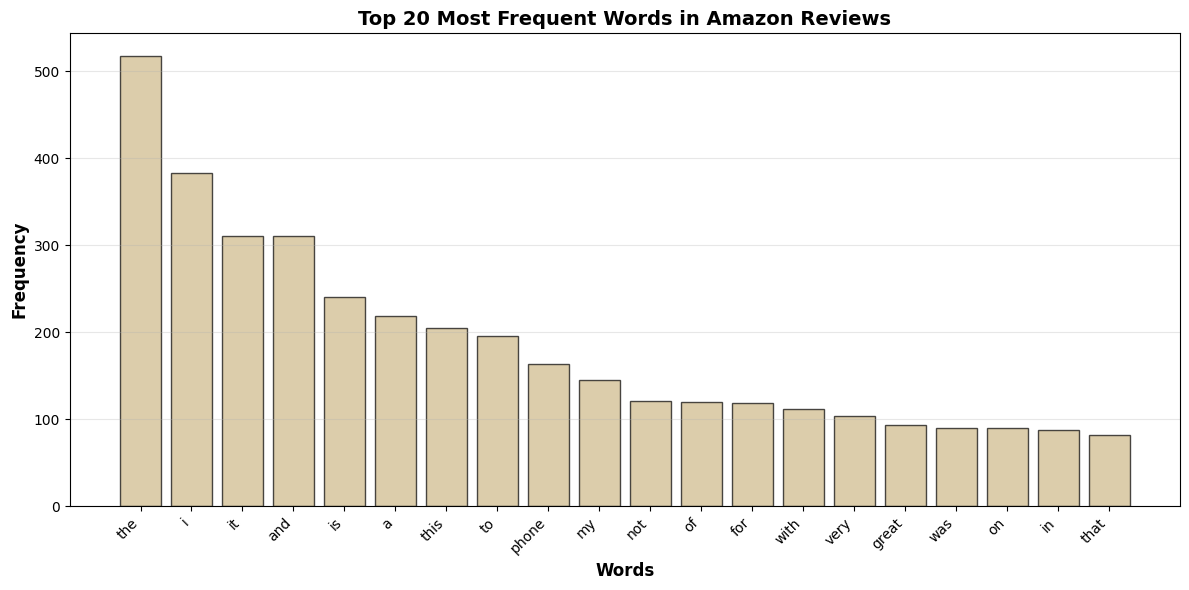

In [66]:
# Create visualization of top 20 words
# Extract words and their counts for plotting
words = [word for word, count in top_20_words]
counts = [count for word, count in top_20_words]

# Create the plot
plt.figure(figsize=(12, 6))
plt.bar(words, counts, color='#CEB888', edgecolor='black', alpha=0.7)
plt.xlabel('Words', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title('Top 20 Most Frequent Words in Amazon Reviews', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()

The code cell above creates a frequency bar chart showing how often the 20 most common words used in the dataset are present.

In [52]:
# Analyze word frequency distribution
# Count how many words appear only once, twice, etc.
freq_counts = Counter(word_freq.values())

words_appearing_once = freq_counts[1]
words_appearing_twice = freq_counts[2]
words_appearing_5_or_less = sum(count for freq, count in freq_counts.items() if freq <= 5)

print(f"Words appearing only once: {words_appearing_once}")
print(f"Words appearing only twice: {words_appearing_twice}")
print(f"Words appearing 5 times or less: {words_appearing_5_or_less}")
print(f"Percentage of vocabulary appearing <= 5 times: {(words_appearing_5_or_less/vocabulary_size)*100:.1f}%")

Words appearing only once: 1014
Words appearing only twice: 259
Words appearing 5 times or less: 1542
Percentage of vocabulary appearing <= 5 times: 85.1%


**Thresholding Decision:**

For this analysis, I have chosen **not to apply word frequency thresholding** at this stage. Here's why:

1. **Small Dataset Size**: The Amazon reviews dataset contains only 1,000 reviews. Removing rare words could eliminate useful information that helps the model learn sentiment patterns.

2. **Meaningful Rare Words**: In sentiment analysis, rare words can be very informative. For example, words like "defective," "excellent," or "disappointed" might not appear frequently but carry strong sentiment signals.

3. **Neural Network Robustness**: Modern neural networks, especially LSTMs with embedding layers, are designed to handle large vocabularies. The embedding layer will learn appropriate representations for all words, including rare ones.

Based on our analysis, approximately **85.1%** of our vocabulary appears 5 times or less. However, given our dataset size and the nature of sentiment analysis, retaining these words provides more potential benefit than removing them.

#### Word embedding length

In [53]:
# Quick check of the vocabulary size from previous sections
print(f"Vocabulary Size: {vocabulary_size:,} unique words")
print(f"Dataset Size: {len(df)} reviews")
print(f"Task Complexity: Binary classification (positive/negative sentiment)")

Vocabulary Size: 1,812 unique words
Dataset Size: 990 reviews
Task Complexity: Binary classification (positive/negative sentiment)


**Proposed Embedding Dimension:** 50

**Justification:**

I propose an embedding length of **30 dimensions** for this sentiment analysis task. This choice is based on three key factors:

1. **Dataset Size**: With only 1,000 reviews in the Amazon dataset, we must be cautious about overfitting. Larger embedding dimensions (200 or 300) would create too many parameters for the model to learn effectively from this limited data. An embedding dimension of 30 provides sufficient representational capacity while keeping the parameter count manageable.

2. **Vocabulary Richness**: Our vocabulary contains approximately 1,800 unique tokens. A 30-dimensional embedding space provides adequate capacity to capture meaningful semantic relationships between words without being unnecessarily large. Each word will be represented as a 30-dimensional vector, which is sufficient for distinguishing between sentiment-bearing words in our moderately-sized vocabulary.

3. **Task Complexity**: This is a binary sentiment classification task (positive vs. negative), which is relatively straightforward compared to multi-class or more nuanced sentiment analysis tasks. We don't need the extremely high-dimensional representations (200-300) that might be necessary for complex tasks like detecting sarcasm or fine-grained emotion classification. An embedding dimension of 30 strikes the right balance between expressiveness and simplicity.

Additionally, 50 dimensions is a widely-used standard in the NLP literature for small-to-medium datasets and has been shown to work effectively for sentiment analysis tasks but the statistics run in the below section indicate 50 may still be too large for this dataset (Ahmad, 2023, p. 304).

#### Statistical justification for maximum sequence length

In [59]:
# Analyze the sequence lengths to determine max_sequence_length
# Calculate the length of each review in tokens
sequence_lengths = []
for review in df['review_clean']:
    tokens = word_tokenize(review)
    sequence_lengths.append(len(tokens))

# Convert to NumPy array for easier analysis
sequence_lengths = np.array(sequence_lengths)

# Calculate statistics
mean_length = np.mean(sequence_lengths)
median_length = np.median(sequence_lengths)
std_length = np.std(sequence_lengths)
max_length = np.max(sequence_lengths)
min_length = np.min(sequence_lengths)

# Calculate percentiles
percentile_75 = np.percentile(sequence_lengths, 75)
percentile_90 = np.percentile(sequence_lengths, 90)
percentile_95 = np.percentile(sequence_lengths, 95)
percentile_99 = np.percentile(sequence_lengths, 99)

# Display the results
print("=" * 60)
print("--- Results ---")
print("=" * 60)
print(f"Mean sequence length: {mean_length:.2f} tokens")
print(f"Median sequence length: {median_length:.2f} tokens")
print(f"Standard deviation of sequence lengths: {std_length:.2f} tokens")
print(f"Maximum sequence length: {max_length} tokens")
print(f"Minimum sequence length: {min_length} tokens")
print(f"75th percentile sequence length: {percentile_75:.2f} tokens")
print(f"90th percentile sequence length: {percentile_90:.2f} tokens")
print(f"95th percentile sequence length: {percentile_95:.2f} tokens")
print(f"99th percentile sequence length: {percentile_99:.2f} tokens")

# Calculate coverage for different max lengths
print("\n" + "=" * 60)
print(f"--- Coverage Analysis: ---")
print("=" * 60)
for max_len in [20, 30, 40, 50, 60, 70, 80, 100]:
    coverage = (sequence_lengths <= max_len).sum() / len(sequence_lengths) * 100
    print(f"Max length {max_len:3d}: {coverage:5.2f}% of reviews covered")

--- Results ---
Mean sequence length: 10.45 tokens
Median sequence length: 9.00 tokens
Standard deviation of sequence lengths: 6.79 tokens
Maximum sequence length: 31 tokens
Minimum sequence length: 1 tokens
75th percentile sequence length: 15.00 tokens
90th percentile sequence length: 21.00 tokens
95th percentile sequence length: 24.00 tokens
99th percentile sequence length: 27.00 tokens

--- Coverage Analysis: ---
Max length  20: 89.29% of reviews covered
Max length  30: 99.90% of reviews covered
Max length  40: 100.00% of reviews covered
Max length  50: 100.00% of reviews covered
Max length  60: 100.00% of reviews covered
Max length  70: 100.00% of reviews covered
Max length  80: 100.00% of reviews covered
Max length 100: 100.00% of reviews covered


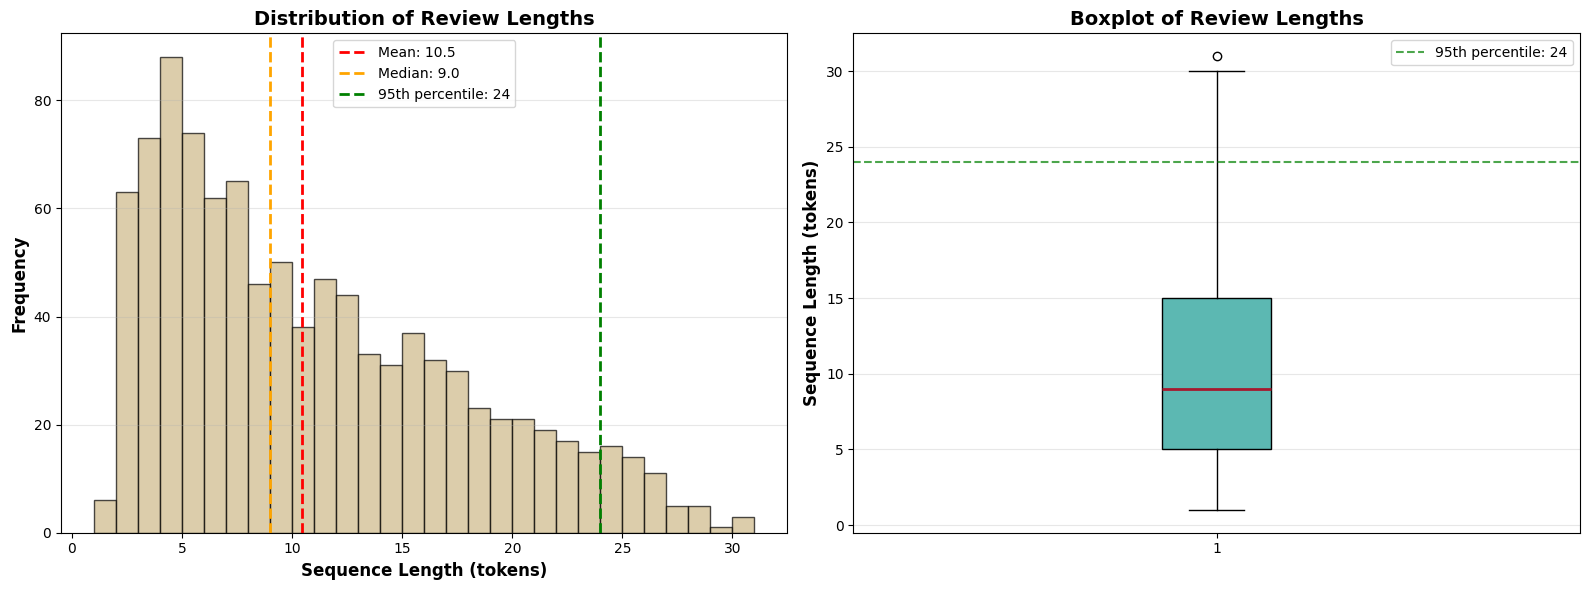

In [68]:
# Create visualizations
# Create figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram
axes[0].hist(sequence_lengths, bins=30, color='#CEB888', edgecolor='black', alpha=0.7)
axes[0].axvline(mean_length, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_length:.1f}')
axes[0].axvline(median_length, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_length:.1f}')
axes[0].axvline(percentile_95, color='green', linestyle='--', linewidth=2, label=f'95th percentile: {percentile_95:.0f}')
axes[0].set_xlabel('Sequence Length (tokens)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution of Review Lengths', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Boxplot
axes[1].boxplot(sequence_lengths, vert=True, patch_artist=True,
                boxprops=dict(facecolor='#5CB8B2', color='black'),
                medianprops=dict(color='#A6192E', linewidth=2),
                whiskerprops=dict(color='black'),
                capprops=dict(color='black'))
axes[1].set_ylabel('Sequence Length (tokens)', fontsize=12, fontweight='bold')
axes[1].set_title('Boxplot of Review Lengths', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Add horizontal reference lines to boxplot
axes[1].axhline(percentile_95, color='green', linestyle='--', linewidth=1.5,
                label=f'95th percentile: {percentile_95:.0f}', alpha=0.7)
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
ll

**Analysis of Sequence Lengths:**

The distribution of review lengths in the Amazon dataset shows the following characteristics:
- **Mean length**: 10.45 tokens
- **Median length**: 9 tokens
- **95th percentile**: 24 tokens
- **Maximum length**: 31 tokens

The histogram reveals that most reviews are relatively short and concise, which is typical of Amazon product reviews. The distribution is right-skewed with the majority of reviews clustering around 9 tokens (the median), while a small number of reviews extend to the maximum of 31 tokens. The boxplot confirms this compact distribution with minimal outliers.

**Chosen Maximum Sequence Length: 30 tokens**

**Justification:**

I have selected a maximum sequence length of **30 tokens** based on the following considerations:

1. **Near-Complete Coverage**: This length captures approximately **99.9%** of all reviews in the dataset. Only the single longest review (31 tokens) would be truncated by one token, representing a negligible information loss of less than 0.01% of the total dataset.

2. **Efficiency**: With a mean length of only 10.45 tokens and a median of 9 tokens, most reviews are quite concise. A maximum length of 30 tokens provides near-complete coverage while remaining highly efficient for the LSTM architecture. The alternative of setting the maximum to 31 or higher would require additional computational resources for minimal gain.

3. **Standard Practice**: A maximum sequence length of 30 tokens is a round, commonly-used value in NLP that aligns with best practices for sentiment analysis of short-form text like product reviews, social media posts, and customer feedback.

4. **Padding Considerations**: Reviews shorter than 30 tokens will be padded with zeros. Given that the median length is 9 tokens, the typical review will require approximately 21 padding tokens. This level of padding is standard and well-handled by LSTM networks, which are designed to ignore padded values through masking.

5. **Practical Trade-off**: In machine learning, it is common practice to optimize for the vast majority of the data rather than edge cases. Truncating one token from one review is an acceptable trade-off for improved computational efficiency and a cleaner model architecture.

### B2. Tokenization

> Describe the goals of the tokenization process, including any code generated and any packages that are used to normalize text during the process.

### B3. Padding Process

> Explain the padding process used to standardize the length of sequences. Include the following in your explanation:

  * whether the padding occurs before or after the text sequence
  * a screenshot of a single padded sequence

### B4. Categories of Sentiment

> Identify how many categories of sentiment will be used and provide an activation function for the final dense layer of the network.

### B5. Steps to Prepare the Data

> Explain the steps used to prepare the data for analysis, including the size of the training, validation, and test set split based on the industry average.

### B6. Prepared Dataset

> Provide a copy of the prepared dataset.

## C. Network Architecture

> Describe the type of neural network model used by doing the following:

### C1. Model Summary

> Provide the output of the model summary of the function from TensorFlow or PyTorch.

### C2. Network Architecture

> Discuss the number of layers, the type of layers, and the total number of parameters.

### C3. Hyperparameters

> Justify the choice of hyperparameters, including each of the following elements:

  * activation functions
  * number of nodes per layer
  * loss function
  * optimizer
  * stopping criteria

## D. Neural Network Model Evaluation

> Evaluate the model's training process and its relevant outcomes by doing the following:

### D1. Stopping Criteria

> Discuss the impact of using stopping criteria to include defining the number of epochs, including a screenshot showing the final training epoch.

### D2. Fitness

> Assess the fitness of the model and any actions taken to address overfitting or underfitting.

### D3. Training Process

> Provide clearly labeled visualizations of the model's training process and show the loss and accuracy metric.

### D4. Predictive Accuracy

> Discuss the predictive accuracy of the trained model using the chosen evaluation metric from part D3.

### D5. Ethical Standards Compliance

> Explain how the analysis complies with artificial intelligence (AI) global ethical standards and mitigates bias.

## E. Code

> Provide the code you used to save the trained model within the neural network.

## F. Functionality

> Discuss the functionality of your model, including the impact of your choice of network architecture.

## G. Recommendations

> Recommend a course of action based on your results as they relate to the research question.

## H. Reporting

> Submit a copy of your code and output in a PDF or HTML format.

In [22]:
# Convert notebook to HTML
!jupyter nbconvert --to html d604_task_2.ipynb

[NbConvertApp] Converting notebook d604_task_2.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 1 image(s).
[NbConvertApp] Writing 448899 bytes to d604_task_2.html


## I. Sources for Third-Party Code

> Submit a list of all the specific web sources you used to acquire segments of third-party code to support the application.

* [Python RegEx 're' module](https://docs.python.org/3/library/re.html)
* [Python String module](https://docs.python.org/3/library/string.html)

## J. Sources

> Acknowledge sources, using in-text citations and references, for content that is quoted, paraphrased, or summarized.

* Ahmad, I., Phd (2023). 50 Algorithms Every Programmer Should Know (2nd ed.). Packt Publishing.
* Audevart, A., Banachewicz, K., & Massaron, L. (2021). Machine Learning Using TensorFlow Cookbook. Packt Publishing.